# Setup

In [4]:
using Pkg; Pkg.activate("..")

using VegaLite
using Dates
using Feather
using DataFrames
using DataFramesMeta
using Statistics

srcdir = joinpath("..","src")
include(joinpath(srcdir,"count_lengths.jl"))
plotdir = joinpath("..","plots","individual_sim_$(Date(now()))")
datadir = joinpath("..","data","count_lengths","run_2018-10-04")


1:225

# Load data

In [5]:
params = Feather.read(joinpath(datadir,"individual_levels_params.feather"))
params[:pindex] = 1:size(params,1)

results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...)

┌ Warning: `ismatch(r::Regex, s::AbstractString)` is deprecated, use `occursin(r, s)` instead.
│   caller = for_results_in(::getfield(Main, Symbol("##31#32")), ::String) at count_lengths.jl:22
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:22
┌ Info: Loading results_params00001_00015.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00016_00030.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00031_00045.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00046_00060.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00061_00075.jld2
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/count_lengths.jl:23
┌ Info: Loading results_params00076_00090.jld2
└ @

21756×4 DataFrame
│ Row   │ length  │ percepts │ created                 │ pindex │
│       │ Float64 │ Int64    │ DateTime                │ Int64  │
├───────┼─────────┼──────────┼─────────────────────────┼────────┤
│ 1     │ 47.52   │ 1        │ 2018-10-04T17:17:16.761 │ 1      │
│ 2     │ 47.52   │ 1        │ 2018-10-04T17:18:24.461 │ 1      │
│ 3     │ 47.52   │ 1        │ 2018-10-04T17:18:32.578 │ 1      │
│ 4     │ 47.52   │ 1        │ 2018-10-04T17:18:38.75  │ 1      │
│ 5     │ 47.52   │ 1        │ 2018-10-04T17:18:44.805 │ 1      │
│ 6     │ 47.52   │ 1        │ 2018-10-04T17:18:50.969 │ 1      │
│ 7     │ 47.52   │ 1        │ 2018-10-04T17:18:57.428 │ 1      │
│ 8     │ 47.52   │ 1        │ 2018-10-04T17:19:03.676 │ 1      │
│ 9     │ 47.52   │ 1        │ 2018-10-04T17:19:10.056 │ 1      │
│ 10    │ 47.52   │ 1        │ 2018-10-04T17:19:16.32  │ 1      │
⋮
│ 21746 │ 1.68    │ 1        │ 2018-10-04T17:48:22.067 │ 225    │
│ 21747 │ 6.0     │ 2        │ 2018-10-04T17:48:22.067 │ 225    │
│ 21748 │ 0.96    │ 1        │ 2018-10-04T17:48:22.067 │ 225    │
│ 21749 │ 6.72    │ 2        │ 2018-10-04T17:48:22.067 │ 225    │
│ 21750 │ 4.56    │ 2        │ 2018-10-04T17:48:28.02  │ 225    │
│ 21751 │ 4.56    │ 1        │ 2018-10-04T17:48:28.02  │ 225    │
│ 21752 │ 1.92    │ 2        │ 2018-10-04T17:48:28.02  │ 225    │
│ 21753 │ 0.96    │ 1        │ 2018-10-04T17:48:28.02  │ 225    │
│ 21754 │ 11.04   │ 2        │ 2018-10-04T17:48:28.02  │ 225    │
│ 21755 │ 0.96    │ 1        │ 2018-10-04T17:48:28.02  │ 225    │
│ 21756 │ 23.52   │ 2        │ 2018-10-04T17:48:28.02  │ 225    │

# proportion streaming

In [23]:
function streamprop(percepts,seconds;bound=true)
  if bound && length(percepts) < 3
    return missing
  end

  if !bound || (sum(seconds[2:end-1]) > 0.8sum(seconds))
    sum(seconds[percepts .== 2]) / sum(seconds)
  else
    cut = seconds[2:end-1]
    sum(cut[percepts .== 2]) / sum(cut)
  end
end

streamprop (generic function with 1 method)

In [24]:
df_summary = @linq df |>
  by(:pindex,
     num_sims = length(unique(:created)),
     N = max(0,length(:created)-2),
     streamprop = streamprop(:percepts,:length,bound=true)) |>
  join(params,on = :pindex) |>
  transform(f_c_a = round.(:f_c_a), f_c_m = round.(:f_c_m),
            s_c_a = round.(:s_c_a), s_c_m = round.(:s_c_m),
            t_c_a = round.(:t_c_a), t_c_m = round.(:t_c_m))

225×39 DataFrame. Omitted printing of 32 columns
│ Row │ pindex │ num_sims │ N     │ streamprop │ f_W_m_σ │ f_c_m   │ t_c_a   │
│     │ Int64  │ Int64    │ Int64 │ Float64    │ Float64 │ Float64 │ Float64 │
├─────┼────────┼──────────┼───────┼────────────┼─────────┼─────────┼─────────┤
│ 1   │ 1      │ 20       │ 18    │ 0.0        │ 5.6     │ 0.0     │ 0.0     │
│ 2   │ 2      │ 20       │ 18    │ 0.0        │ 5.6     │ 18.0    │ 0.0     │
│ 3   │ 3      │ 20       │ 18    │ 0.0        │ 5.6     │ 32.0    │ 0.0     │
│ 4   │ 4      │ 20       │ 18    │ 0.0        │ 5.6     │ 56.0    │ 0.0     │
│ 5   │ 5      │ 20       │ 18    │ 0.0        │ 5.6     │ 100.0   │ 0.0     │
│ 6   │ 6      │ 20       │ 18    │ 0.0        │ 5.6     │ 0.0     │ 0.0     │
│ 7   │ 7      │ 20       │ 18    │ 0.0        │ 5.6     │ 18.0    │ 0.0     │
│ 8   │ 8      │ 20       │ 18    │ 0.0        │ 5.6     │ 32.0    │ 0.0     │
│ 9   │ 9      │ 20       │ 18    │ 0.0        │ 5.6     │ 56.0    │ 0.0     │
│ 10  │ 10     │ 20       │ 18    │ 0.0        │ 5.6     │ 100.0   │ 0.0     │
⋮
│ 215 │ 215    │ 20       │ 176   │ 0.844192   │ 5.6     │ 0.0     │ 56.0    │
│ 216 │ 216    │ 20       │ 58    │ 0.979798   │ 5.6     │ 0.0     │ 0.0     │
│ 217 │ 217    │ 20       │ 76    │ 0.958333   │ 5.6     │ 0.0     │ 5.0     │
│ 218 │ 218    │ 20       │ 138   │ 0.888636   │ 5.6     │ 0.0     │ 11.0    │
│ 219 │ 219    │ 20       │ 273   │ 0.743182   │ 5.6     │ 0.0     │ 25.0    │
│ 220 │ 220    │ 20       │ 236   │ 0.79697    │ 5.6     │ 0.0     │ 56.0    │
│ 221 │ 221    │ 20       │ 30    │ 0.993939   │ 5.6     │ 0.0     │ 0.0     │
│ 222 │ 222    │ 20       │ 74    │ 0.967929   │ 5.6     │ 0.0     │ 5.0     │
│ 223 │ 223    │ 20       │ 76    │ 0.955556   │ 5.6     │ 0.0     │ 11.0    │
│ 224 │ 224    │ 20       │ 205   │ 0.811111   │ 5.6     │ 0.0     │ 25.0    │
│ 225 │ 225    │ 20       │ 224   │ 0.840152   │ 5.6     │ 0.0     │ 56.0    │

WARN column encoding should be discrete (ordinal / nominal / binned).


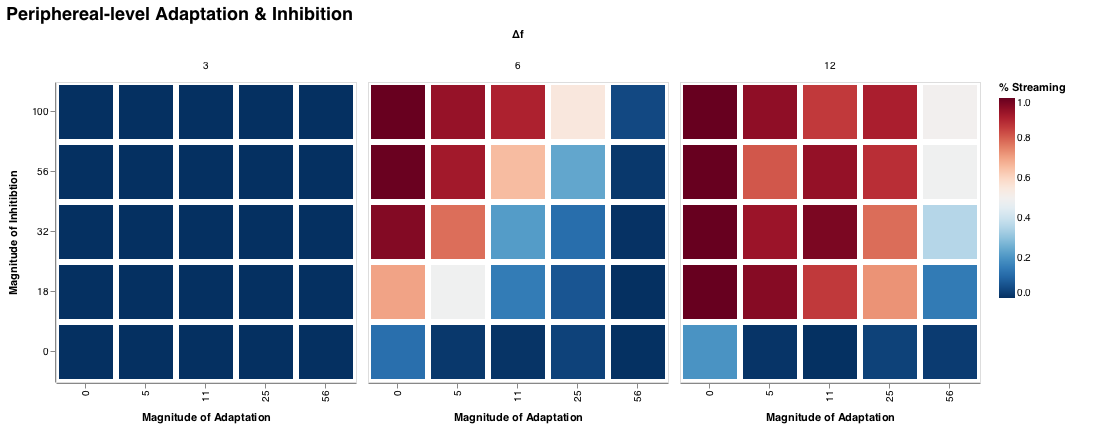

WARN column encoding should be discrete (ordinal / nominal / binned).


In [30]:
@where(df_summary,:f_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Periphereal-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:f_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:f_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


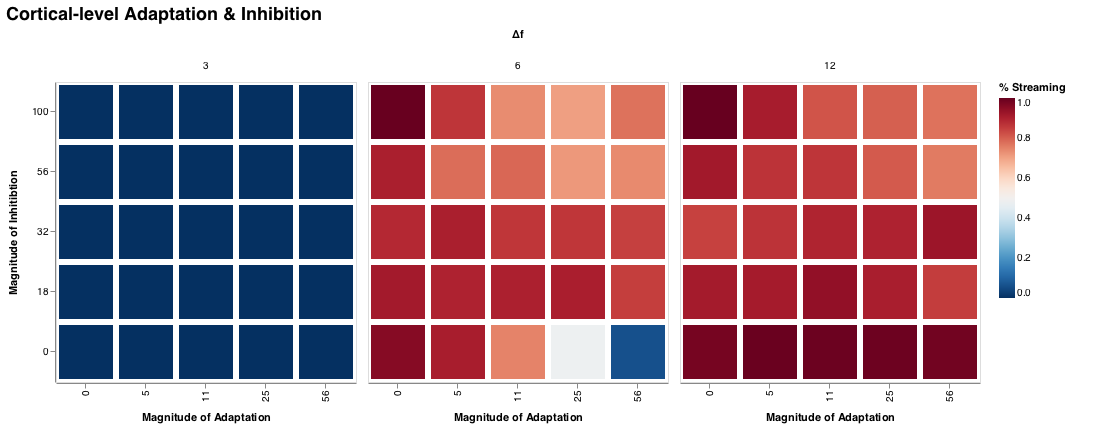

In [31]:
@where(df_summary,:s_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Cortical-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:s_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:s_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).


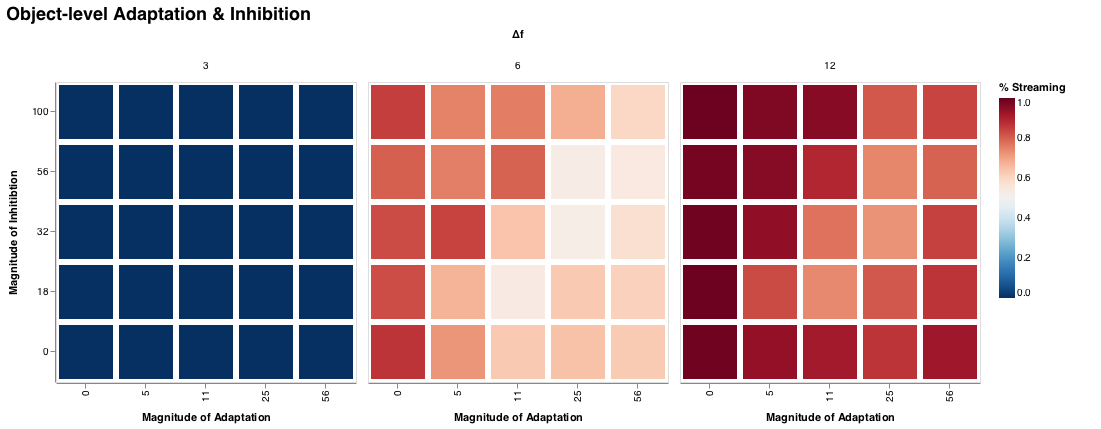

WARN column encoding should be discrete (ordinal / nominal / binned).


In [32]:
@where(df_summary,:t_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Object-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:t_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:t_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# RMS of streaming selectivity

In [33]:
mean_human = [0.11, 0.55, 0.89]
function stream_rms(str3,str6,str12)
  vec(sqrt.(mean((hcat(str3,str6,str12) .- mean_human').^2,dims=2)))
end

stream_rms (generic function with 1 method)

In [34]:
df_stream_rms = @linq copy(df_summary) |>
  delete!(:pindex) |>
  delete!(:N) |>
  delete!(:num_sims) |>
  unstack(:Δf,:streamprop) |>
  rename(Symbol("3") => :Δf_3,Symbol("6") => :Δf_6,Symbol("12") => :Δf_12) |>
  transform(stream_rms = stream_rms(:Δf_3,:Δf_6,:Δf_12))

75×38 DataFrame. Omitted printing of 31 columns
│ Row │ f_W_m_σ │ f_c_m   │ t_c_a   │ t_c_m   │ f       │ t_W_m_c │ t_c_x   │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 2   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 3   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 4   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 5   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 6   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 7   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 8   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 9   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 10  │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
⋮
│ 65  │ 5.6     │ 32.0    │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 66  │ 5.6     │ 56.0    │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 67  │ 5.6     │ 56.0    │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 68  │ 5.6     │ 56.0    │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 69  │ 5.6     │ 56.0    │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 70  │ 5.6     │ 56.0    │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 71  │ 5.6     │ 100.0   │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 72  │ 5.6     │ 100.0   │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 73  │ 5.6     │ 100.0   │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 74  │ 5.6     │ 100.0   │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │
│ 75  │ 5.6     │ 100.0   │ 0.0     │ 0.0     │ 500.0   │ 6.0     │ 3.0     │

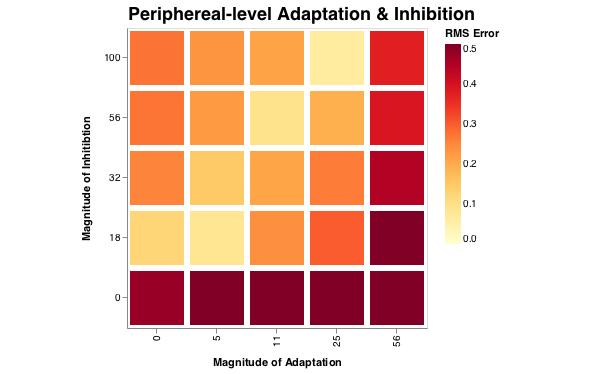

In [50]:
@where(df_stream_rms,:f_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Periphereal-level Adaptation & Inhibition",fontSize=18},
          x={field=:f_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:f_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="stream_rms", aggregate="mean", typ="quantitative",
                 legend={title="RMS Error"}, scale={domain=[0,0.5]}},
          config={range={heatmap={scheme="yelloworangered"}}})

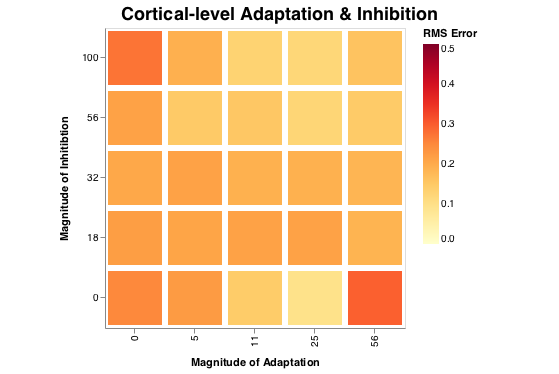

In [51]:
@where(df_stream_rms,:s_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Cortical-level Adaptation & Inhibition",fontSize=18},
          x={field=:s_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:s_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="stream_rms", aggregate="mean", typ="quantitative",
                 legend={title="RMS Error"}, scale={domain=[0,0.5]}},
          config={range={heatmap={scheme="yelloworangered"}}})

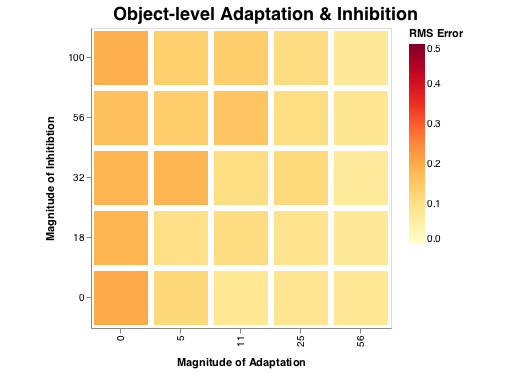

In [52]:
@where(df_stream_rms,:t_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Object-level Adaptation & Inhibition",fontSize=18},
          x={field=:t_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:t_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="stream_rms", aggregate="mean", typ="quantitative",
                 legend={title="RMS Error"}, scale={domain=[0,0.5]}},
          config={range={heatmap={scheme="yelloworangered"}}})

# Thoughts

Okay... that all looks encouraging. Next steps:

1. Combine the last three plots into one plot
2. Plot some of the individuals masks, see how they look.
3. Plot some other measures: N, W, and some sort of aggregate RMS
4. In parallel, begin to run the interaction condition